In [82]:
import torch

Load the data

In [90]:
import torchvision
from torchvision import transforms, datasets

batch_size = 16

image_size = 224

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.Resize(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


test_transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show some of the images and labels of the loaded image

truck plane  frog truck  bird   dog  ship plane   car   cat  ship truck  deer horse   cat   dog


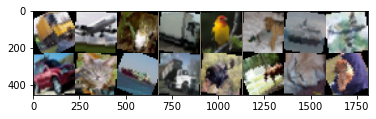

In [103]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


# get some random training images
images, labels = iter(trainloader).next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [104]:
from torch import nn, optim
from collections import OrderedDict
from torchvision import models

dropout_prob = 0.4
learning_rate = 0.001
input_size = 25088
hidden_size = 16
output_size = 10

model = models.vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = True
model.classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_size)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(dropout_prob)),
                                        ('fc2', nn.Linear(hidden_size, output_size)),
                                        ('output', nn.LogSoftmax(dim=1))]))


Set loss function

In [105]:
criterion = nn.NLLLoss()

Set optimizer

In [106]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Use gpu if available

In [110]:
print("Is GPU available : " + 'Yes' if torch.cuda.is_available() else 'No' )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model = nn.DataParallel(model)

No


Start training

In [111]:
epochs = 1
print_every = 1
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % print_every == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / print_every))
            running_loss = 0.0

print('Finished Training')

[1,     0] loss: 5.957
[1,     1] loss: 2.304
[1,     2] loss: 2.413
[1,     3] loss: 2.339
[1,     4] loss: 2.314
[1,     5] loss: 2.321
[1,     6] loss: 2.274
[1,     7] loss: 2.380
[1,     8] loss: 2.357
[1,     9] loss: 2.315
[1,    10] loss: 2.255
[1,    11] loss: 2.263
[1,    12] loss: 2.312
[1,    13] loss: 2.327
[1,    14] loss: 2.281
[1,    15] loss: 2.293
[1,    16] loss: 2.438
[1,    17] loss: 2.306
[1,    18] loss: 2.298
[1,    19] loss: 2.293
[1,    20] loss: 2.259
[1,    21] loss: 2.295
[1,    22] loss: 2.361
[1,    23] loss: 2.292
[1,    24] loss: 2.262
[1,    25] loss: 2.332
[1,    26] loss: 2.341
[1,    27] loss: 2.289
[1,    28] loss: 2.312
[1,    29] loss: 2.302
[1,    30] loss: 2.333
[1,    31] loss: 2.276
[1,    32] loss: 2.369
[1,    33] loss: 2.217
[1,    34] loss: 2.317
[1,    35] loss: 2.339
[1,    36] loss: 2.331
[1,    37] loss: 2.352
[1,    38] loss: 2.257
[1,    39] loss: 2.325
[1,    40] loss: 2.288
[1,    41] loss: 2.341
[1,    42] loss: 2.333
[1,    43] 

KeyboardInterrupt: 

Save the trained model

In [112]:
PATH = './checkpoint.pth'
torch.save(model.state_dict(), PATH)

Test the trained model.
First load a batch and see the actual values. 
Then predict using our model and compare

Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


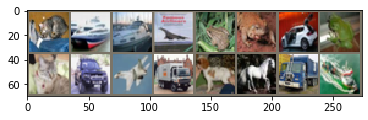

In [116]:
images, labels = iter(testloader).next()

imshow(torchvision.utils.make_grid(images))
print('Real labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Load the saved model

In [114]:
saved_model = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_size)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(dropout_prob)),
                                        ('fc2', nn.Linear(hidden_size, output_size)),
                                        ('output', nn.LogSoftmax(dim=1))]))
saved_model.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "module.module.module.features.0.weight", "module.module.module.features.0.bias", "module.module.module.features.2.weight", "module.module.module.features.2.bias", "module.module.module.features.5.weight", "module.module.module.features.5.bias", "module.module.module.features.7.weight", "module.module.module.features.7.bias", "module.module.module.features.10.weight", "module.module.module.features.10.bias", "module.module.module.features.12.weight", "module.module.module.features.12.bias", "module.module.module.features.14.weight", "module.module.module.features.14.bias", "module.module.module.features.17.weight", "module.module.module.features.17.bias", "module.module.module.features.19.weight", "module.module.module.features.19.bias", "module.module.module.features.21.weight", "module.module.module.features.21.bias", "module.module.module.features.24.weight", "module.module.module.features.24.bias", "module.module.module.features.26.weight", "module.module.module.features.26.bias", "module.module.module.features.28.weight", "module.module.module.features.28.bias", "module.module.module.classifier.fc1.weight", "module.module.module.classifier.fc1.bias", "module.module.module.classifier.fc2.weight", "module.module.module.classifier.fc2.bias". 

Predict using our model

In [117]:

_, predicted = torch.max(torch.exp(model.forward(images)), dim=1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:   deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer  deer


Check the accuracy on the test data

In [119]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


### References

- [Learning Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

- [Training a Classifier - Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)